In [1]:
import os,sys,netCDF4, pandas as pd,statsmodels.api as sm
from statsmodels.formula.api import ols

# Get dir name of parent directory
modfol=os.path.dirname(os.getcwd())
sys.path.insert(0, modfol)

# Complete import statements 
import GeneralFunctions as GF, numpy as np, matplotlib.pyplot as plt, pandas as pd

# Set Data directory
datadir=modfol+"/Data/"


# Summit Climate Censitivity to Global Mean Temperature Change 

In [2]:
# Read in each model run (pressure and tas -- daily), extract 1981-2099, and compute the monthly
files=["%s/Projections/"%datadir+ii for ii in os.listdir("%s/Projections/"%datadir) if "tas" not in ii]
yrst=1981; yrstp=2099
mondata={}
for f in files:
    # Use cdo to process to monthly - cleaner dong this with MOHC 36-day calendar!
    fail=os.system("cdo -L -s monmean -selyear,1981/2099 %s /tmp/scratch.nc"%f); assert fail==0   
    fobj=netCDF4.Dataset("/tmp/scratch.nc","r")
    ta=fobj.variables["Temp"] 
    press=fobj.variables["Pressure"]
    time=fobj.variables["time"] 
    year,mon,day,hour,pyTimes=GF.conTimes(time_str=time.units,calendar=time.calendar\
                                      ,times=time[:],safe=True)
    mondata[f.split("/")[-1].replace(".nc","_ta")]=ta[:]
    mondata[f.split("/")[-1].replace(".nc","_press")]=press[:]
    print "Processed file: %s" % f
    os.system("rm /tmp/scratch.nc")
mondata=pd.DataFrame(mondata,index=pyTimes)   

Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/IPSL_IPSL-CM5B-LR_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/CMCC_CMCC-CESM_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/MIROC_MIROC-ESM-CHEM_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/LASG-CESS_FGOALS-g2_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/CCCma_CanESM2_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/BNU_BNU-ESM_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/NCC_NorESM1-M_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/BCC_bcc-csm1-1-m_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/NOAA-GFDL_GFDL-CM3_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/NOAA-GFDL_GFDL-ESM2G_rcp85.nc
Processed file: /home/lunet/gytm3/EverestShare/Data//Projections/MRI_MRI-CGCM3_rcp85.nc
P

In [3]:
# Now for each column (series) in mondata, look for the global mean temp model run, 
# and read in to its own pandas DataFrame
runs=[ii.replace("ta","tas") for ii in mondata.columns if "ta" in ii]
tasdata={}; models=[]
for r in runs:
    if r+".nc" in os.listdir("%s/Projections/" % datadir):
        cmd="cdo -L -s monmean -selyear,1981/2099 %sProjections/%s.nc /tmp/scratch.nc" %(datadir,r)
        fail=os.system(cmd ); assert fail==0
        fobj=netCDF4.Dataset("/tmp/scratch.nc","r")
        tasdata[r]=np.squeeze(fobj.variables["tas"][:])
        time=fobj.variables["time"]
        year,mon,day,hour,pyTimes=GF.conTimes(time_str=time.units,calendar=time.calendar\
                                      ,times=time[:],safe=True)
        print "Processed file: %s" % r
        os.system("rm /tmp/scratch.nc")
        
tasmondata=pd.DataFrame(tasdata,index=pyTimes) 

Processed file: BCC_bcc-csm1-1-m_rcp85_tas
Processed file: BNU_BNU-ESM_rcp85_tas
Processed file: CCCma_CanESM2_rcp85_tas
Processed file: CMCC_CMCC-CMS_rcp85_tas
Processed file: CMCC_CMCC-CM_rcp85_tas
Processed file: CSIRO-BOM_ACCESS1-0_rcp85_tas
Processed file: CSIRO-BOM_ACCESS1-3_rcp85_tas
Processed file: IPSL_IPSL-CM5A-LR_rcp85_tas
Processed file: IPSL_IPSL-CM5A-MR_rcp85_tas
Processed file: IPSL_IPSL-CM5B-LR_rcp85_tas
Processed file: MIROC_MIROC-ESM-CHEM_rcp85_tas
Processed file: MIROC_MIROC-ESM_rcp85_tas
Processed file: MIROC_MIROC5_rcp85_tas
Processed file: MOHC_HadGEM2-CC_rcp85_tas
Processed file: MPI-M_MPI-ESM-MR_rcp85_tas
Processed file: MRI_MRI-CGCM3_rcp85_tas
Processed file: NCC_NorESM1-M_rcp85_tas
Processed file: NOAA-GFDL_GFDL-CM3_rcp85_tas
Processed file: NOAA-GFDL_GFDL-ESM2G_rcp85_tas



## Determining Scaling Coefficients for Monthly Mean Values
Here we smooth both the local response variable (ta and press) and the global mean temperature variable. The smoothing is carried out to consistently define "climate" (30-year periods) and to result in more stable parameter estimates. 

To facilitate the analysis, we split all data on month and perform separate regressions. We then perform an ANOVA to assess whether month makes a difference to the slope coefficients. 

In [36]:
# Add a month variable to facilitate separate monthly analysis
mondata["month"]=mondata.index.month
tasmondata["month"]=tasmondata.index.month

# Allocations
tas_slopes={}
press_slopes={}
month=range(1,13)
models=[ii for ii in list(tasmondata.columns.values) if "month" not in ii]
ensemble=np.zeros((len(models)*len(month),3))*np.nan

# Nested loop to apply separate regressions for each month and model 
counter=0; mod_list=[]
for mod in models:
    
    for m in month:
               
        # The y(s)
        tas_loc_sm=mondata[mod.replace("tas","ta")][mondata["month"]==m].rolling(30).mean()
        press_loc_sm=mondata[mod.replace("tas","press")][tasmondata["month"]==m].rolling(30).mean()
        
        # The x
        tas_glob_sm=tasmondata[mod][tasmondata["month"]==m].rolling(30).mean()
        
        # The regressions
        idx=~np.isnan(tas_loc_sm)
        ensemble[counter,0],intercept_tas=np.polyfit(tas_glob_sm[idx]-tas_glob_sm[idx][0],\
                                           tas_loc_sm[idx]-tas_loc_sm[idx][0],1)
        ensemble[counter,1],intercept_press=np.polyfit(tas_glob_sm[idx]-tas_glob_sm[idx][0]\
                                               ,press_loc_sm[idx]-press_loc_sm[idx][0],1)
        ensemble[counter,2]=m
        mod_list.append(mod)
        
        # Increment!
        counter+=1
        
# Put in ANOVA-friendly array        
ensemble=pd.DataFrame({"tas_slope":ensemble[:,0],"press_slope":ensemble[:,1],"month": ensemble[:,2]},\
                     index=mod_list)
# Calibrate models 
mod_tas = ols('tas_slope ~ C(month)',
                data=ensemble).fit()

mod_press=ols('press_slope ~ C(month)',
                data=ensemble).fit()
# Do ANOVA and display results
aov_tas = sm.stats.anova_lm(mod_tas, typ=2)
aov_press = sm.stats.anova_lm(mod_press, typ=2)
print "\t\t<-- Temperature results --> \n", aov_tas
print "\n\t\t<-- Pressure results --> \n", aov_press

		<-- Temperature results --> 
             sum_sq     df         F        PR(>F)
C(month)   5.257127   11.0  6.378426  3.955101e-09
Residual  16.184378  216.0       NaN           NaN

		<-- Pressure results --> 
                 sum_sq     df        F    PR(>F)
C(month)    2012.215657   11.0  0.22284  0.995914
Residual  177314.151114  216.0      NaN       NaN


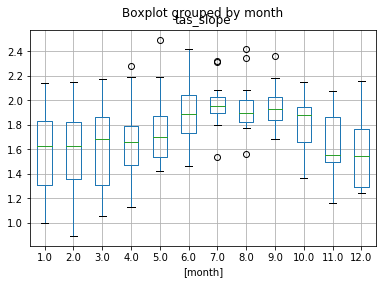

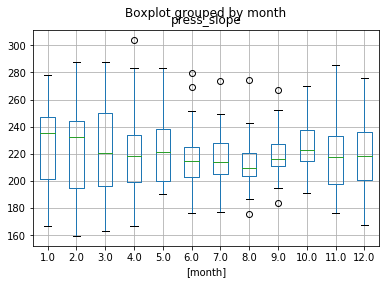

In [29]:
ensemble[["tas_slope","month"]].boxplot(by="month")
ensemble[["press_slope","month"]].boxplot(by="month")

To summarise the results from the above, we see that air temperature sensitivity to global mean air temp does seem to depend on the month; pressure does not.

# Exploring Trends in Variability 